https://github.com/JMoura10/Sistemas-Inteligentes

The following code predicts a quantitative measure of disease progression one year after baseline, using 10 baseline variables.
All the necessary libraries were imported at the beginning of the code for organisational and clarity purposes.

In [1]:
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score
import skfuzzy as fuzz
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import pandas

Having all the necessary libraries imported, the dataset to be used was loaded, and the 10 baseline variables and the target were identified.

In [2]:
# Load dataset
diabetes = datasets.load_diabetes(as_frame=True)
x = diabetes.data
y = diabetes.target.values

Before performing any type of modelling, it is extremely important to split the data into two different sets, one for training and the other for testing. While the training data will be used to build the model, the test data will be used to evaluate its performance. The test set is smaller than the training set so that most of the data could be used to train the model, but it has to be large enough to provide a reliable evaluation. In this case, 20% of the total data was used for testing. This step is crucial because the model should be tested on unseen data, which is data that was not used to build it. Otherwise, the model might appear perfect, and it would not reflect its real performance for new data.

In [3]:
# Splitting data into train and test
test_size = 0.2
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=42)

Since the features of the dataset were in different scales, standardisation was applied. This way, the data was transformed so that each feature has zero mean and unit variance, allowing a comparison between them.

In [4]:
# Standardise features
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

After preparing the data, fuzzy c-means clustering was applied. This method partitioned the data into a pre-defined number of clusters, and each cluster corresponded to a rule that was later used on the TSK (Takagi-Sugeno) model.
The number of clusters and the parameter m, which controls how wide the membership function is, were tuned in order to reduce the MSE (Mean Squared Error), leading to a more reliable model.
The clustering returns, among other outputs, the centres and membership degrees of each cluster.

In [5]:
# Number of clusters 
n_clusters = 4
m=2

# Concatenate target for clustering
x_exp=np.concatenate([x_train, y_train.reshape(-1, 1)], axis=1)

# Transpose data for skfuzzy (expects features x samples)
x_exp_T = x_exp.T 

# Fuzzy C-means clustering
centers, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    x_exp_T, n_clusters, m=m, error=0.005, maxiter=1000, init=None,
)
centers.shape

(4, 11)

Then, the spread of each cluster, represented by sigma, was computed using the membership degrees as weights. These values were later used as parameters for the Gaussian formula in the TSK model.

In [6]:
# Compute sigma (spread) for each cluster
sigmas = []
for j in range(n_clusters):
    # membership weights for cluster j, raised to m
    u_j = u[j, :] ** m
    # weighted variance for each feature
    var_j = np.average((x_exp - centers[j])**2, axis=0, weights=u_j)
    sigma_j = np.sqrt(var_j)
    sigmas.append(sigma_j)
sigmas=np.array(sigmas)

Once the fuzzy clustering was computed, a hard partition of the samples was obtained by assigning each point to the cluster where it had the highest membership degree. A scatter plot was also made, where the transparency of each point reflects its membership degree to the respective cluster.

Fuzzy partition coefficient (FPC): 0.7803444467363637


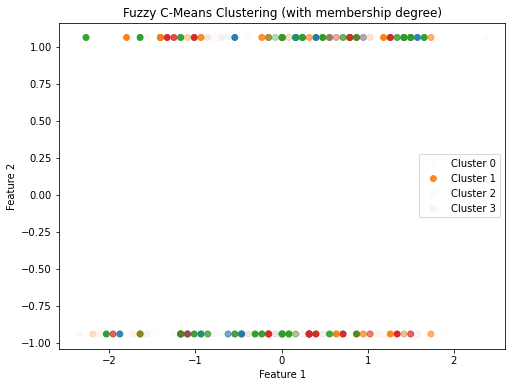

In [7]:
# Hard clustering from fuzzy membership
cluster_labels = np.argmax(u, axis=0)
print("Fuzzy partition coefficient (FPC):", fpc)

# Plot first two features with fuzzy membership
plt.figure(figsize=(8,6))
for j in range(n_clusters):
    plt.scatter(
        x_exp[cluster_labels == j, 0],             # Feature 1
        x_exp[cluster_labels == j, 1],             # Feature 2
        alpha=u[j, :],          # transparency ~ membership
        label=f'Cluster {j}'
    )

plt.title("Fuzzy C-Means Clustering (with membership degree)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

The aspect of the graph is explained by the nature of Feature 2. Since it represents the sex of the person, a binary feature, it only takes two values and the points align in two horizontal lines.

The next step was to plot the Gaussian membership function for each cluster, using its centre and spread. The resulting curves illustrate how the membership degree of each cluster varies across the range of the feature.

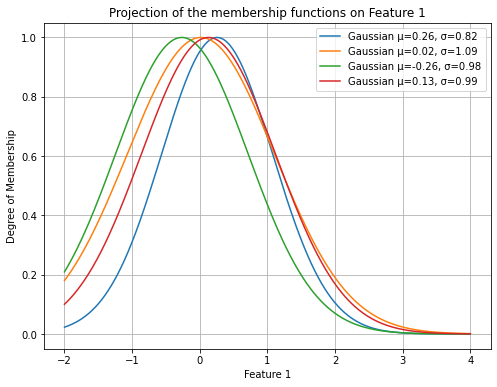

In [8]:
# Gaussian formula
def gaussian(x, mu, sigma):
    return np.exp(-0.5 * ((x - mu)/sigma)**2)

lin=np.linspace(-2, 4, 500)
plt.figure(figsize=(8,6))

y_aux=[]
for j in range(n_clusters):
# Compute curves
    y_aux.append(gaussian(lin, centers[j,0], sigmas[j,0])) # only use centres and sigmas

# Plot
    plt.plot(lin, y_aux[j], label=f"Gaussian μ={np.round(centers[j,0],2)}, σ={np.round(sigmas[j,0],2)}")

plt.title("Projection of the membership functions on Feature 1")
plt.xlabel("Feature 1")
plt.ylabel("Degree of Membership")
plt.legend()
plt.grid(True)
plt.show()

The TSK model was implemented using information already computed before. In a TSK model, the overall output is a weighted average of the rule inputs. The antecedents of the model were represented by the Gaussian membership functions, characterised by the centres and spread of each cluster obtained from fuzzy c-means clustering. The consequents were defined as linear functions of the inputs, with each rule having its own coefficients for each input and a bias.

In [9]:
# Implementation of TSK
# ---------------------------
# Gaussian Membership Function
# ---------------------------
class GaussianMF(nn.Module):
    def __init__(self, centers, sigmas, agg_prob):
        super().__init__()
        self.centers = nn.Parameter(torch.tensor(centers, dtype=torch.float32))
        self.sigmas = nn.Parameter(torch.tensor(sigmas, dtype=torch.float32))
        self.agg_prob=agg_prob

    def forward(self, x):
        # Expand for broadcasting
        # x: (batch, 1, n_dims), centers: (1, n_rules, n_dims), sigmas: (1, n_rules, n_dims)
        diff = abs((x.unsqueeze(1) - self.centers.unsqueeze(0))/self.sigmas.unsqueeze(0)) #(batch, n_rules, n_dims)

        # Aggregation
        if self.agg_prob:
            dist = torch.norm(diff, dim=-1)  # (batch, n_rules) # probablistic intersection
        else:
            dist = torch.max(diff, dim=-1).values  # (batch, n_rules) # min intersection (min instersection of normal funtion is the same as the max on dist)
        
        return torch.exp(-0.5 * dist ** 2)


# ---------------------------
# TSK Model
# ---------------------------
class TSK(nn.Module):
    def __init__(self, n_inputs, n_rules, centers, sigmas,agg_prob=False):
        super().__init__()
        self.n_inputs = n_inputs
        self.n_rules = n_rules

        # Antecedents (Gaussian MFs)
        
        self.mfs=GaussianMF(centers, sigmas,agg_prob) 

        # Consequents (linear functions of inputs)
        # Each rule has coeffs for each input + bias
        self.consequents = nn.Parameter(
            torch.randn(n_inputs + 1,n_rules)
        )

    def forward(self, x):
        # x: (batch, n_inputs)
        batch_size = x.shape[0]
        
        # Compute membership values for each input feature
        # firing_strengths: (batch, n_rules)
        firing_strengths = self.mfs(x)
        
        # Normalize memberships
        # norm_fs: (batch, n_rules)
        norm_fs = firing_strengths / (firing_strengths.sum(dim=1, keepdim=True) + 1e-9)

        # Consequent output (linear model per rule)
        x_aug = torch.cat([x, torch.ones(batch_size, 1)], dim=1)  # add bias

        rule_outputs = torch.einsum("br,rk->bk", x_aug, self.consequents)  # (batch, rules)
        # Weighted sum
        output = torch.sum(norm_fs * rule_outputs, dim=1, keepdim=True)

        return output, norm_fs, rule_outputs

A least squares solver was implemented to determine the values of the coefficients of the consequents for the TSK model. It combined the normalised firing strengths with the input data to create a design matrix, and then solved for the coefficients that best fit the training outputs.

In [10]:
# ---------------------------
# Least Squares Solver for Consequents (TSK)
# ---------------------------
def train_ls(model, x, y):
    with torch.no_grad():
        _, norm_fs, _ = model(x)

        # Design matrix for LS: combine normalized firing strengths with input
        X_aug = torch.cat([x, torch.ones(x.shape[0], 1)], dim=1)
        
        phi = torch.einsum("br,bi->bri", X_aug, norm_fs).reshape(x.shape[0], -1)
        
        # Solve LS: consequents = (Phi^T Phi)^-1 Phi^T y
        
        theta= torch.linalg.lstsq(phi, y).solution
        
        model.consequents.data = theta.reshape(model.consequents.shape)

The model was ready to be built, using the previously obtained results for the antecedents and consequents.

In [11]:
# Build model
# create instance of the model before training it
model = TSK(n_inputs=x_train.shape[1], n_rules=n_clusters, centers=centers[:,:-1], sigmas=sigmas[:,:-1])

x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

Having built the model, it was trained employing the least squares solver defined above.

In [12]:
# Training with LS
train_ls(model, x_train, y_train.reshape(-1,1))

Finally, the model was evaluated on the test set, and its performance was measured using the MSE and R². These metrics assessed how well the model's outputs matched the target values. 

In [13]:
y_pred, _, _=model(x_test)

mse = mean_squared_error(y_test.detach().numpy(),y_pred.detach().numpy())
print(f'MSE: {mse}')

r2 = r2_score(y_test.detach().numpy(), y_pred.detach().numpy())
print(f'R²: {r2}')

MSE: 2529.00146484375
R²: 0.5226634599225066
